# COGS 181: Final Project: 2 Layer MaxPool Adam
### By: Rebecca Du (PID A16284217)

## Imports

In [1]:
%env KMP_DUPLICATE_LIB_OK=TRUE

env: KMP_DUPLICATE_LIB_OK=TRUE


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

## Step 1: Prepare for Dataset

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


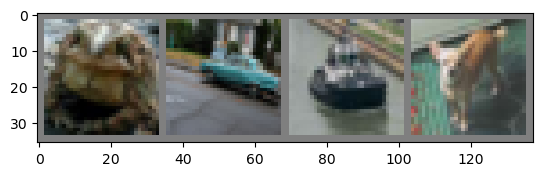

 frog   car  ship   dog


In [4]:
# The function to show an image.
def imshow(img):
    img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get some random training images.
dataiter = iter(trainloader)
images, labels = next(dataiter)
# Show images.
imshow(torchvision.utils.make_grid(images))
# Print labels.
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

#### Choose a Device 

In [5]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cpu


## Step 2: Network Definition

- For this notebook, we are using a **2 convolutional block** network

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #First convolutional block
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        
        #Second convolutional block
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        
        #Pooling
        self.pool = nn.MaxPool2d(2, 2)
        
        #Dropout
        self.dropout = nn.Dropout(0.5)
        
        #FC Layers
        self.fc1 = nn.Linear(64 * 8 * 8, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        #First convolutional block
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        
        #Second convolutional block
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        
        x = x.view(-1, 64 * 8 * 8)
        x = self.dropout(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

Net(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=4096, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
)

## Step 3: Optimizer and Loss Function

In [7]:
# We use cross-entropy as loss function.
loss_func = nn.CrossEntropyLoss()  
# We use stochastic gradient descent (SGD) as optimizer.
opt = optim.Adam(net.parameters(), lr=0.001)

## Step 4: Training Procedure

In [8]:
avg_losses = []   # Avg. losses.
epochs = 10       # Total epochs.
print_freq = 100  # Print frequency.

for epoch in range(epochs):  # Loop over the dataset multiple times.
    running_loss = 0.0       # Initialize running loss.
    for i, data in enumerate(trainloader, 0):
        # Get the inputs.
        inputs, labels = data
        
        # Move the inputs to the specified device.
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Zero the parameter gradients.
        opt.zero_grad()

        # Forward step.
        outputs = net(inputs)
        loss = loss_func(outputs, labels)
        
        # Backward step.
        loss.backward()
        
        # Optimization step (update the parameters).
        opt.step()

        # Print statistics.
        running_loss += loss.item()
        if i % print_freq == print_freq - 1: # Print every several mini-batches.
            avg_loss = running_loss / print_freq
            print('[epoch: {}, i: {:5d}] avg mini-batch loss: {:.3f}'.format(
                epoch, i, avg_loss))
            avg_losses.append(avg_loss)
            running_loss = 0.0

print('Finished Training.')

[epoch: 0, i:    99] avg mini-batch loss: 2.431
[epoch: 0, i:   199] avg mini-batch loss: 2.082
[epoch: 0, i:   299] avg mini-batch loss: 2.032
[epoch: 0, i:   399] avg mini-batch loss: 1.942
[epoch: 0, i:   499] avg mini-batch loss: 1.862
[epoch: 0, i:   599] avg mini-batch loss: 1.776
[epoch: 0, i:   699] avg mini-batch loss: 1.800
[epoch: 0, i:   799] avg mini-batch loss: 1.777
[epoch: 0, i:   899] avg mini-batch loss: 1.793
[epoch: 0, i:   999] avg mini-batch loss: 1.662
[epoch: 0, i:  1099] avg mini-batch loss: 1.671
[epoch: 0, i:  1199] avg mini-batch loss: 1.616
[epoch: 0, i:  1299] avg mini-batch loss: 1.656
[epoch: 0, i:  1399] avg mini-batch loss: 1.595
[epoch: 0, i:  1499] avg mini-batch loss: 1.687
[epoch: 0, i:  1599] avg mini-batch loss: 1.604
[epoch: 0, i:  1699] avg mini-batch loss: 1.649
[epoch: 0, i:  1799] avg mini-batch loss: 1.593
[epoch: 0, i:  1899] avg mini-batch loss: 1.634
[epoch: 0, i:  1999] avg mini-batch loss: 1.668
[epoch: 0, i:  2099] avg mini-batch loss

[epoch: 1, i:  4699] avg mini-batch loss: 1.090
[epoch: 1, i:  4799] avg mini-batch loss: 1.126
[epoch: 1, i:  4899] avg mini-batch loss: 1.154
[epoch: 1, i:  4999] avg mini-batch loss: 1.187
[epoch: 1, i:  5099] avg mini-batch loss: 1.134
[epoch: 1, i:  5199] avg mini-batch loss: 1.126
[epoch: 1, i:  5299] avg mini-batch loss: 1.212
[epoch: 1, i:  5399] avg mini-batch loss: 1.079
[epoch: 1, i:  5499] avg mini-batch loss: 1.061
[epoch: 1, i:  5599] avg mini-batch loss: 1.197
[epoch: 1, i:  5699] avg mini-batch loss: 1.042
[epoch: 1, i:  5799] avg mini-batch loss: 1.131
[epoch: 1, i:  5899] avg mini-batch loss: 1.096
[epoch: 1, i:  5999] avg mini-batch loss: 1.103
[epoch: 1, i:  6099] avg mini-batch loss: 1.068
[epoch: 1, i:  6199] avg mini-batch loss: 1.106
[epoch: 1, i:  6299] avg mini-batch loss: 1.211
[epoch: 1, i:  6399] avg mini-batch loss: 1.074
[epoch: 1, i:  6499] avg mini-batch loss: 0.999
[epoch: 1, i:  6599] avg mini-batch loss: 1.046
[epoch: 1, i:  6699] avg mini-batch loss

[epoch: 2, i:  9299] avg mini-batch loss: 1.025
[epoch: 2, i:  9399] avg mini-batch loss: 0.991
[epoch: 2, i:  9499] avg mini-batch loss: 0.989
[epoch: 2, i:  9599] avg mini-batch loss: 1.106
[epoch: 2, i:  9699] avg mini-batch loss: 0.937
[epoch: 2, i:  9799] avg mini-batch loss: 0.924
[epoch: 2, i:  9899] avg mini-batch loss: 1.026
[epoch: 2, i:  9999] avg mini-batch loss: 0.995
[epoch: 2, i: 10099] avg mini-batch loss: 0.989
[epoch: 2, i: 10199] avg mini-batch loss: 1.011
[epoch: 2, i: 10299] avg mini-batch loss: 0.957
[epoch: 2, i: 10399] avg mini-batch loss: 0.960
[epoch: 2, i: 10499] avg mini-batch loss: 0.908
[epoch: 2, i: 10599] avg mini-batch loss: 1.053
[epoch: 2, i: 10699] avg mini-batch loss: 1.049
[epoch: 2, i: 10799] avg mini-batch loss: 0.993
[epoch: 2, i: 10899] avg mini-batch loss: 1.013
[epoch: 2, i: 10999] avg mini-batch loss: 1.026
[epoch: 2, i: 11099] avg mini-batch loss: 1.004
[epoch: 2, i: 11199] avg mini-batch loss: 1.112
[epoch: 2, i: 11299] avg mini-batch loss

[epoch: 4, i:  1399] avg mini-batch loss: 0.894
[epoch: 4, i:  1499] avg mini-batch loss: 0.896
[epoch: 4, i:  1599] avg mini-batch loss: 0.902
[epoch: 4, i:  1699] avg mini-batch loss: 0.872
[epoch: 4, i:  1799] avg mini-batch loss: 0.943
[epoch: 4, i:  1899] avg mini-batch loss: 0.952
[epoch: 4, i:  1999] avg mini-batch loss: 0.907
[epoch: 4, i:  2099] avg mini-batch loss: 1.040
[epoch: 4, i:  2199] avg mini-batch loss: 0.875
[epoch: 4, i:  2299] avg mini-batch loss: 0.948
[epoch: 4, i:  2399] avg mini-batch loss: 0.853
[epoch: 4, i:  2499] avg mini-batch loss: 0.967
[epoch: 4, i:  2599] avg mini-batch loss: 0.883
[epoch: 4, i:  2699] avg mini-batch loss: 0.901
[epoch: 4, i:  2799] avg mini-batch loss: 0.926
[epoch: 4, i:  2899] avg mini-batch loss: 0.866
[epoch: 4, i:  2999] avg mini-batch loss: 0.843
[epoch: 4, i:  3099] avg mini-batch loss: 0.928
[epoch: 4, i:  3199] avg mini-batch loss: 0.888
[epoch: 4, i:  3299] avg mini-batch loss: 0.940
[epoch: 4, i:  3399] avg mini-batch loss

[epoch: 5, i:  5999] avg mini-batch loss: 0.816
[epoch: 5, i:  6099] avg mini-batch loss: 0.696
[epoch: 5, i:  6199] avg mini-batch loss: 0.920
[epoch: 5, i:  6299] avg mini-batch loss: 0.886
[epoch: 5, i:  6399] avg mini-batch loss: 0.897
[epoch: 5, i:  6499] avg mini-batch loss: 0.870
[epoch: 5, i:  6599] avg mini-batch loss: 0.914
[epoch: 5, i:  6699] avg mini-batch loss: 0.813
[epoch: 5, i:  6799] avg mini-batch loss: 0.832
[epoch: 5, i:  6899] avg mini-batch loss: 0.844
[epoch: 5, i:  6999] avg mini-batch loss: 0.845
[epoch: 5, i:  7099] avg mini-batch loss: 0.733
[epoch: 5, i:  7199] avg mini-batch loss: 0.870
[epoch: 5, i:  7299] avg mini-batch loss: 0.809
[epoch: 5, i:  7399] avg mini-batch loss: 0.736
[epoch: 5, i:  7499] avg mini-batch loss: 0.919
[epoch: 5, i:  7599] avg mini-batch loss: 1.001
[epoch: 5, i:  7699] avg mini-batch loss: 0.851
[epoch: 5, i:  7799] avg mini-batch loss: 0.971
[epoch: 5, i:  7899] avg mini-batch loss: 0.825
[epoch: 5, i:  7999] avg mini-batch loss

[epoch: 6, i: 10599] avg mini-batch loss: 0.664
[epoch: 6, i: 10699] avg mini-batch loss: 0.883
[epoch: 6, i: 10799] avg mini-batch loss: 0.839
[epoch: 6, i: 10899] avg mini-batch loss: 0.814
[epoch: 6, i: 10999] avg mini-batch loss: 0.926
[epoch: 6, i: 11099] avg mini-batch loss: 0.777
[epoch: 6, i: 11199] avg mini-batch loss: 0.798
[epoch: 6, i: 11299] avg mini-batch loss: 0.723
[epoch: 6, i: 11399] avg mini-batch loss: 0.811
[epoch: 6, i: 11499] avg mini-batch loss: 0.884
[epoch: 6, i: 11599] avg mini-batch loss: 0.829
[epoch: 6, i: 11699] avg mini-batch loss: 0.976
[epoch: 6, i: 11799] avg mini-batch loss: 0.861
[epoch: 6, i: 11899] avg mini-batch loss: 0.782
[epoch: 6, i: 11999] avg mini-batch loss: 0.819
[epoch: 6, i: 12099] avg mini-batch loss: 0.777
[epoch: 6, i: 12199] avg mini-batch loss: 0.875
[epoch: 6, i: 12299] avg mini-batch loss: 0.891
[epoch: 6, i: 12399] avg mini-batch loss: 0.737
[epoch: 6, i: 12499] avg mini-batch loss: 0.844
[epoch: 7, i:    99] avg mini-batch loss

[epoch: 8, i:  2699] avg mini-batch loss: 0.742
[epoch: 8, i:  2799] avg mini-batch loss: 0.689
[epoch: 8, i:  2899] avg mini-batch loss: 0.678
[epoch: 8, i:  2999] avg mini-batch loss: 0.738
[epoch: 8, i:  3099] avg mini-batch loss: 0.818
[epoch: 8, i:  3199] avg mini-batch loss: 0.676
[epoch: 8, i:  3299] avg mini-batch loss: 0.809
[epoch: 8, i:  3399] avg mini-batch loss: 0.713
[epoch: 8, i:  3499] avg mini-batch loss: 0.698
[epoch: 8, i:  3599] avg mini-batch loss: 0.775
[epoch: 8, i:  3699] avg mini-batch loss: 0.888
[epoch: 8, i:  3799] avg mini-batch loss: 0.872
[epoch: 8, i:  3899] avg mini-batch loss: 0.879
[epoch: 8, i:  3999] avg mini-batch loss: 0.784
[epoch: 8, i:  4099] avg mini-batch loss: 0.775
[epoch: 8, i:  4199] avg mini-batch loss: 0.771
[epoch: 8, i:  4299] avg mini-batch loss: 0.838
[epoch: 8, i:  4399] avg mini-batch loss: 0.667
[epoch: 8, i:  4499] avg mini-batch loss: 0.709
[epoch: 8, i:  4599] avg mini-batch loss: 0.746
[epoch: 8, i:  4699] avg mini-batch loss

[epoch: 9, i:  7299] avg mini-batch loss: 0.799
[epoch: 9, i:  7399] avg mini-batch loss: 0.748
[epoch: 9, i:  7499] avg mini-batch loss: 0.724
[epoch: 9, i:  7599] avg mini-batch loss: 0.642
[epoch: 9, i:  7699] avg mini-batch loss: 0.763
[epoch: 9, i:  7799] avg mini-batch loss: 0.750
[epoch: 9, i:  7899] avg mini-batch loss: 0.743
[epoch: 9, i:  7999] avg mini-batch loss: 0.677
[epoch: 9, i:  8099] avg mini-batch loss: 0.785
[epoch: 9, i:  8199] avg mini-batch loss: 0.687
[epoch: 9, i:  8299] avg mini-batch loss: 0.620
[epoch: 9, i:  8399] avg mini-batch loss: 0.818
[epoch: 9, i:  8499] avg mini-batch loss: 0.700
[epoch: 9, i:  8599] avg mini-batch loss: 0.757
[epoch: 9, i:  8699] avg mini-batch loss: 0.816
[epoch: 9, i:  8799] avg mini-batch loss: 0.737
[epoch: 9, i:  8899] avg mini-batch loss: 0.731
[epoch: 9, i:  8999] avg mini-batch loss: 0.806
[epoch: 9, i:  9099] avg mini-batch loss: 0.792
[epoch: 9, i:  9199] avg mini-batch loss: 0.683
[epoch: 9, i:  9299] avg mini-batch loss

### Training Loss Curve

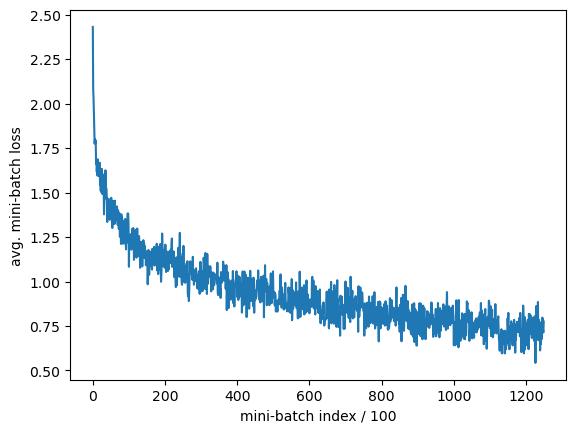

In [9]:
plt.plot(avg_losses)
plt.xlabel('mini-batch index / {}'.format(print_freq))
plt.ylabel('avg. mini-batch loss')
plt.show()

## Step 5: Evaluate on Test Dataset

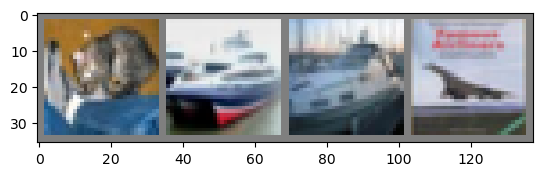

GroundTruth:    cat  ship  ship plane
Predicted:    cat  ship plane plane


In [10]:
# Check several images.
dataiter = iter(testloader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))

In [11]:
# Get test accuracy for each class.
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 72 %
Accuracy of   car : 80 %
Accuracy of  bird : 58 %
Accuracy of   cat : 45 %
Accuracy of  deer : 53 %
Accuracy of   dog : 65 %
Accuracy of  frog : 80 %
Accuracy of horse : 76 %
Accuracy of  ship : 81 %
Accuracy of truck : 77 %
